In [1]:
import onnx
import os
import wandb
import onnxruntime as ort
import numpy as np
from utils_tbm import *
from test_tbmV2 import test as evals

In [2]:
model = onnx.load(os.getcwd()+"/modelV2.onnx")
(onnx.checker.check_model(model))

In [ ]:
print(model)

In [4]:
train_data, _ = get_data_from_csv('../../preplogs_model2.csv', train=True)
test_data, _ = get_data_from_csv('../../preplogs_model2.csv', train=False)
test_loader = make_loader(test_data, batch_size=1)

In [5]:
remote_hosts = get_test_remote_hosts('../../preplogs_model2.csv')

In [6]:
print(len(remote_hosts))

4015


In [7]:
import re
values_reconstruction = []
with open('reconstructionsV2.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        values = re.findall(r'\d+\.\d+e?-?\d*', line)
        # Convert the string values to floats
        values_reconstruction.append(float(values[0]))
        

In [8]:
dict_reconstruction = dict()
for i in range(len(remote_hosts)):
    dict_reconstruction[remote_hosts[i]] = values_reconstruction[i]
max(dict_reconstruction.values())

1.0898553133010864

In [9]:
import matplotlib.pyplot as plt

         Remote Host  Reconstruction Error
2547   87.251.84.146              1.089855
526    74.125.151.97              0.972339
1524   82.223.139.90              0.924887
2008    84.246.85.11              0.903397
527    74.125.151.98              0.842090
1553   82.98.180.126              0.836178
106    66.249.66.200              0.783930
57     66.249.64.164              0.779610
648   77.226.251.249              0.765280
54     66.249.64.161              0.695428


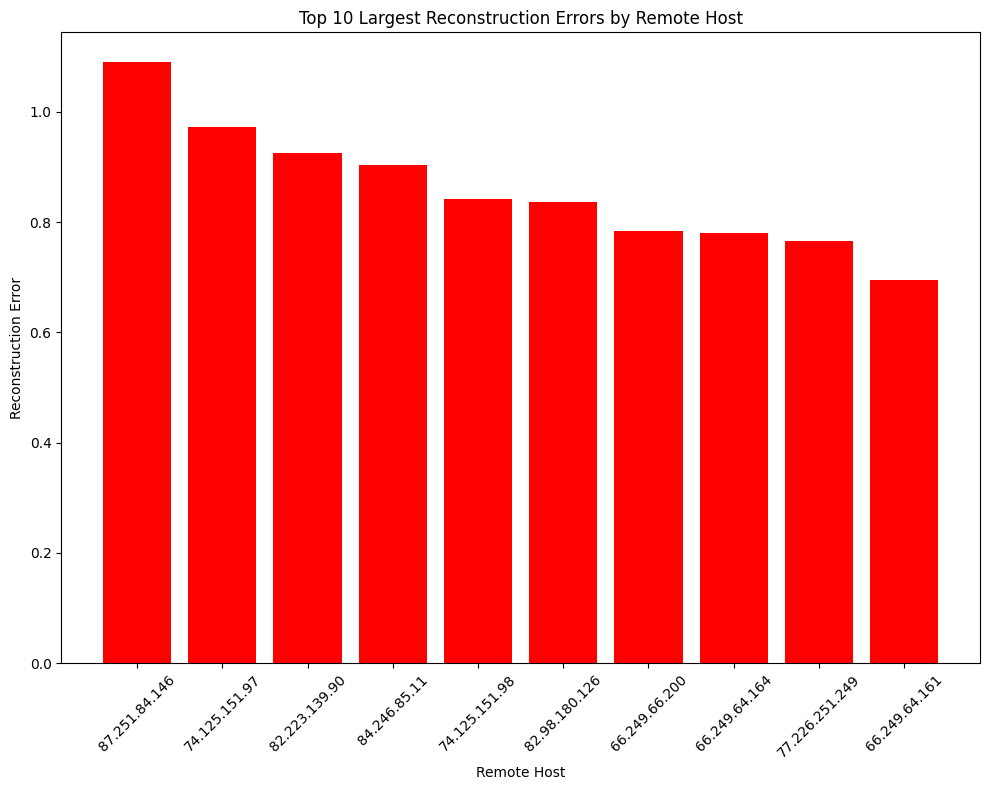

In [11]:
df = pd.DataFrame(list(dict_reconstruction.items()), columns=['Remote Host', 'Reconstruction Error']).sort_values(by='Reconstruction Error', ascending=False)

# select the top 10 records with the largest reconstruction errors
top_10_df = df.head(10)
print(top_10_df)
# plotting
plt.figure(figsize=(10, 8))
plt.bar(top_10_df['Remote Host'], top_10_df['Reconstruction Error'], color = 'red')
plt.xlabel('Remote Host')
plt.ylabel('Reconstruction Error')
plt.title('Top 10 Largest Reconstruction Errors by Remote Host')
plt.xticks(rotation=45)  # rotate x-axis labels for readability
plt.tight_layout()

plt.show()

In [14]:
raw_df = pd.read_csv("../../combined_logs.csv")


In [54]:
import dash
from dash import dash_table
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd

app = dash.Dash(__name__)

indices = top_10_df.index[:3]
observations = []
for idx in indices:
    observation = raw_df[raw_df['remote_host'] == top_10_df['Remote Host'][idx]]
    observations.append(observation)

# Concatenate all observations into a single DataFrame
all_observations = pd.concat(observations, ignore_index=True)

app.layout = html.Div(style={'textAlign': 'center'}, children=[  # Add a style to center the content
    html.H1('Anomalous Logs', style={'textAlign': 'center'}),  # Center the title
    dash_table.DataTable(
        id='observation-table',
        style_table={'overflowX': 'auto'},  # Make the table horizontally scrollable
        columns=[{'name': i, 'id': i} for i in all_observations.columns],
        data=all_observations.to_dict('records')
    )
])

if __name__ == '__main__':
    app.run_server()

In [71]:
import requests
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

tables = []

for idx in indices:
    ip_address = str(top_10_df['Remote Host'][idx])

    response = requests.get(f"https://ipinfo.io/{ip_address}/json")
    data = response.json()

    table_data = [
        {"Property": "IP Address", "Value": ip_address},
        {"Property": "City", "Value": data.get("city", "Not available")},
        {"Property": "Region", "Value": data.get("region", "Not available")},
        {"Property": "Country", "Value": data.get("country", "Not available")},
        {"Property": "Postal", "Value": data.get("postal", "Not available")},
        {"Property": "Latitude", "Value": data.get("loc", "Not available").split(',')[0] if data.get("loc") else "Not available"},
        {"Property": "Longitude", "Value": data.get("loc", "Not available").split(',')[1] if data.get("loc") else "Not available"},
        {"Property": "ASN", "Value": data.get("asn", "Not available")},
        {"Property": "Org", "Value": data.get("org", "Not available")},
    ]

    tables.append(
        dash_table.DataTable(
            id=f"table-{idx}",
            columns=[{"name": i, "id": i} for i in ['Property', 'Value']],
            data=table_data,
            style_table={'overflowX': 'auto'},
            style_data={'overflowX': 'auto'},
            style_header={'backgroundColor': 'white', 'fontWeight': 'bold'},
            style_cell={'textAlign': 'center'}
        )
    )

app.layout = html.Div(style={'textAlign': 'center'}, children=[
    html.H1('IP Information', style={'textAlign': 'center'}),
    html.Div(style={'display': 'flex', 'flexDirection': 'column', 'justifyContent': 'center', 'alignItems': 'center'}, children=[
        table for table in tables
    ])
])

if __name__ == '__main__':
    app.run_server()